# Graph Neural Networks for Survival Prediction: A Novel Biostatistical Approach to the Titanic Dataset

The Titanic dataset is a classic dataset for binary classification (predicting survival: 0 or 1) and has direct relevance to biostatistics, particularly in the domain of survival analysis. Biostatistics applies statistical methods to biological and medical data, often focusing on outcomes like survival, disease progression, or treatment efficacy. Here’s why this project aligns with biostatistical goals:

- Survival Analysis Context: The Titanic dataset involves predicting whether passengers survived the disaster based on features like age, sex, and passenger class. This mirrors survival analysis tasks in biostatistics, where the outcome is a binary event (e.g., survival vs. death). The dataset has been referenced in biostatistical contexts, such as by the Vanderbilt University Department of Biostatistics.
- Population-Level Insights: By using a GNN, the project models passengers as nodes in a graph, with edges representing similarity in characteristics. This approach captures relational patterns (e.g., whether passengers with similar profiles had correlated survival outcomes), which is valuable in biostatistics for understanding population dynamics, such as in epidemiological studies or clinical trials.
- Innovative Methodology: Traditional biostatistical models for survival analysis (e.g., logistic regression, Cox proportional hazards) treat observations as independent. The GNN’s graph-based approach introduces a novel perspective by modeling dependencies between individuals, potentially revealing insights into group-level factors affecting survival (e.g., access to lifeboats based on class or gender).

## 1. Installing Dependencies
Installs the <span style="color:orange">torch-geometric</span> library, which is required for implementing the GCN model. This library is not pre-installed in Kaggle notebooks, so it must be installed at runtime.
- <span style="color:orange">torch-geometric</span> provides tools for graph-based deep learning, including the <span style="color:orange">GCNConv</span> layer used in the model.

Enables the use of advanced graph neural network techniques, which are central to the project’s unique approach.

In [1]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.5 MB/s eta 0:00:00a 0:00:01


## 2. Importing Libraries
- Data Manipulation:
  - <span style="color:orange">pandas (pd):</span> Handles the Titanic dataset as a DataFrame for loading and preprocessing.
  - <span style="color:orange">numpy (np):</span> Supports numerical operations, such as array manipulation.
- Preprocessing:
  - <span style="color:orange">sklearn.preprocessing.StandardScaler:</span> Standardizes features to have zero mean and unit variance, crucial for distance-based graph construction.
  - <span style="color:orange">sklearn.model_selection.train_test_split:</span> Splits data into training and validation sets.
  - <span style="color:orange">sklearn.metrics.pairwise_distances:</span> Computes pairwise distances between passengers for graph construction.
- Deep Learning:
  - <span style="color:orange">torch:</span> PyTorch library for tensor operations and neural network implementation.
  - <span style="color:orange">torch.nn.functional (F):</span> Provides activation functions (e.g., ReLU) and loss functions.
- Graph Neural Networks:
  - <span style="color:orange">torch_geometric.data.Data:</span> Creates a graph data object for GNN processing.
  - <span style="color:orange">torch_geometric.nn.GCNConv:</span> Implements graph convolutional layers for the GCN model.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
import os

## 3. Loading the Dataset
The dataset is stored in <span style="color:orange">/kaggle/input/titanic/train.csv</span>, as added via Kaggle’s data interface.
- <span style="color:orange">pandas.read_csv</span> reads the CSV file into a DataFrame with 891 rows and 12 columns: <span style="color:orange">PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, and Embarked.</span>

The <span style="color:orange">Survived</span> column is the target variable (0 = did not survive, 1 = survived), and other columns are potential features.

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')

## 4. Handling Missing Values
- Embarked:
    - <span style="color:orange">Embarked</span> (port of embarkation: C, Q, S) has 2 missing values.
    - <span style="color:orange">mode()[0]</span> finds the most common value (‘S’).
    - <span style="color:orange">fillna</span> replaces missing values with ‘S’.
- Age:
    - <span style="color:orange">Age</span> has 177 missing values (about 20% of the dataset).
    - <span style="color:orange">mean()</span> computes the average age (approximately 29.7 years).
    - <span style="color:orange">fillna</span> replaces missing values with the mean age.
- <span style="color:orange">inplace=True</span> modifies the DataFrame directly to avoid creating a copy.

In [4]:
most_common_embarked = train['Embarked'].mode()[0]
# train['Embarked'].fillna(most_common_embarked, inplace=True)
train['Embarked'] = train['Embarked'].fillna(most_common_embarked)
mean_age = train['Age'].mean()
# train['Age'].fillna(mean_age, inplace=True)
train['Age'] = train['Age'].fillna(mean_age)

## 5. Encoding Categorical Variables
- Sex:
    - <span style="color:orange">Sex</span> (male, female) is binary and mapped to 0 (male) or 1 (female) using <span style="color:orange">map</span>.
- Embarked:
    - <span style="color:orange">Embarked</span> (C, Q, S) is one-hot encoded using <span style="color:orange">pd.get_dummies</span>, creating three binary columns: <span style="color:orange">Embarked_C, Embarked_Q, Embarked_S</span>.
    - The original <span style="color:orange">Embarked</span> column is dropped.
- Pclass:
    - <span style="color:orange">Pclass</span> (1, 2, 3) is one-hot encoded into <span style="color:orange">Pclass_1, Pclass_2, Pclass_3</span>.
    - The original <span style="color:orange">Pclass</span> column is dropped.
    - <span style="color:orange">pd.concat</span> combines the new dummy columns with the DataFrame, and <span style="color:orange">axis=1</span> ensures concatenation along columns.

Machine learning models, including GNNs, require numerical inputs. One-hot encoding preserves the categorical nature of <span style="color:orange">Embarked</span> and <span style="color:orange">Pclass</span> without implying ordinality, while binary encoding for <span style="color:orange">Sex</span> is efficient. This step prepares the data for feature standardization and graph construction.

In [5]:
train['Sex'] = train['Sex'].map({'male': 0, 'female': 1})
embarked_dummies = pd.get_dummies(train['Embarked'], prefix='Embarked')
train = pd.concat([train, embarked_dummies], axis=1)
train.drop('Embarked', axis=1, inplace=True)
pclass_dummies = pd.get_dummies(train['Pclass'], prefix='Pclass')
train = pd.concat([train, pclass_dummies], axis=1)
train.drop('Pclass', axis=1, inplace=True)

## 6. Dropping Irrelevant Columns
Removes columns that are not useful for modeling due to irrelevance or high missingness.
- PassengerId: A unique identifier with no predictive value.
- Name: Contains passenger names, which are not directly useful without feature engineering (e.g., extracting titles).
- Ticket: Ticket numbers are mostly unique and lack clear predictive patterns.
- Cabin: Has 687 missing values (77% missing) and is too sparse to use effectively.
- <span style="color:orange">axis=1</span> specifies column-wise dropping, and <span style="color:orange">inplace=True</span> modifies the DataFrame.

Simplifies the dataset to focus on predictive features (<span style="color:orange">Age, SibSp, Parch, Fare, Sex, Pclass_1, Pclass_2, Pclass_3, Embarked_C, Embarked_Q, Embarked_S</span>), reducing noise and computational complexity.

In [6]:
train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

## 7. Defining Features and Target
Separates the feature matrix (<span style="color:orange">X</span>) from the target variable (<span style="color:orange">y</span>).
- <span style="color:orange">X</span>: Contains all columns except <span style="color:orange">Survived</span>, resulting in an 891 x 11 matrix (11 features).
- <span style="color:orange">y</span>: The <span style="color:orange">Survived</span> column, a binary vector (0 or 1) with 891 entries.
- <span style="color:orange">drop(axis=1)</span> removes the <span style="color:orange">Survived</span> column from the DataFrame to create <span style="color:orange">X</span>.

Clearly defines the inputs (<span style="color:orange">X</span>) and outputs (<span style="color:orange">y</span>) for the machine learning model, a standard step in supervised learning tasks like survival prediction.

In [7]:
X = train.drop('Survived', axis=1)
y = train['Survived']

## 8. Standardizing Features
Standardizes the features to have zero mean and unit variance, ensuring consistent scales for distance calculations.
- <span style="color:orange">StandardScaler</span> computes the mean and standard deviation for each feature and transforms the data using <span style="color:orange">(x - mean) / std</span>.
- <span style="color:orange">fit_transform</span> fits the scaler to <span style="color:orange">X</span> and transforms it in one step, producing <span style="color:orange">X_scaled</span> (an 891 x 11 NumPy array).
- Standardization is critical because features like <span style="color:orange">Age</span> (range: 0-80) and <span style="color:orange">Fare</span> (range: 0-512) have different scales, which could skew distance-based graph construction.

Ensures that all features contribute equally to the Euclidean distance calculations used to build the graph, improving the quality of the GNN’s relational modeling.

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 9. Splitting Train and Validation Sets
Splits the dataset into 80% training and 20% validation sets to evaluate model performance.
- <span style="color:orange">train_test_split</span> splits the indices (0 to 890) into training (<span style="color:orange">train_idx</span>) and validation (<span style="color:orange">val_idx</span>) sets.
- <span style="color:orange">test_size=0.2</span> allocates 20% (179 samples) for validation and 80% (712 samples) for training.
- <span style="color:orange">random_state=42</span> ensures reproducibility.
- <span style="color:orange">stratify=y</span> maintains the proportion of <span style="color:orange">Survived</span> classes (approximately 38% survived) in both sets.

Allows the model to train on a subset of the data and evaluate generalization on unseen data, a key practice in machine learning to prevent overfitting.

In [9]:
train_idx, val_idx = train_test_split(range(len(X)), test_size=0.2, random_state=42, stratify=y)
print(f"Train set size: {len(train_idx)}, Validation set size: {len(val_idx)}")

Train set size: 712, Validation set size: 179


## 10. Constructing the Graph
Builds a graph where passengers are nodes, and edges connect each passenger to their 5 most similar peers based on feature similarity.
- Distance Calculation:
    - <span style="color:orange">pairwise_distances(X_scaled)</span> computes Euclidean distances between all pairs of passengers, producing an 891 x 891 matrix.
- K-Nearest Neighbors:
    - <span style="color:orange">np.argsort(distances, axis=1)</span> sorts distances for each passenger.
    - <span style="color:orange">[:, 1:k+1]</span> selects the indices of the 5 closest neighbors (excluding the passenger themselves, hence <span style="color:orange">1:k+1</span>).
    - <span style="color:orange">knn_indices</span> is an 891 x 5 array of neighbor indices.
- Edge List:
    - The loop creates edges by pairing each passenger (<span style="color:orange">i</span>) with their neighbors (<span style="color:orange">j</span>).
    - Both <span style="color:orange">[i, j]</span> and <span style="color:orange">[j, i]</span> are added to make the graph undirected.
    - <span style="color:orange">edges</span> is a list of edge pairs.
- Remove Duplicates:
    - <span style="color:orange">np.unique(np.array(edges), axis=0)</span> removes duplicate edges (e.g., [i, j] and [j, i] are equivalent in an undirected graph).

The graph structure is the core of the GNN, enabling the model to learn from relational patterns (e.g., passengers with similar ages or classes may have correlated survival outcomes). This relational approach is novel for the Titanic dataset and aligns with biostatistical interest in population-level interactions.

In [10]:
distances = pairwise_distances(X_scaled)
k = 5
knn_indices = np.argsort(distances, axis=1)[:, 1:k+1]
edges = []
for i in range(len(X)):
    for j in knn_indices[i]:
        edges.append([i, j])
        edges.append([j, i])
edges = np.unique(np.array(edges), axis=0)

## 11. Creating the PyTorch Geometric Data Object
Converts the data into a <span style="color:orange">Data</span> object compatible with PyTorch Geometric for GNN training.
- Node Features:
    - <span style="color:orange">x = torch.tensor(X_scaled, dtype=torch.float)</span> converts the standardized features (891 x 11) to a PyTorch tensor.
- Edge Index:
    - <span style="color:orange">edge_index = torch.tensor(edges.T, dtype=torch.long)</span> converts the edge list to a 2 x M tensor, where M is the number of unique edges. The first row contains source nodes, and the second row contains target nodes.
- Labels:
    - <span style="color:orange">y_torch = torch.tensor(y.values, dtype=torch.long)</span> converts the <span style="color:orange">Survived</span> labels to a tensor of integers (0 or 1).
- Masks:
    - <span style="color:orange">train_mask</span> and <span style="color:orange">val_mask</span> are boolean tensors (length 891) initialized to <span style="color:orange">False</span>.
    - <span style="color:orange">train_mask[train_idx] = True</span> sets <span style="color:orange">True</span> for training indices.
    - <span style="color:orange">val_mask[val_idx] = True</span> sets <span style="color:orange">True</span> for validation indices.
- Data Object:
    - <span style="color:orange">Data</span> combines <span style="color:orange">x, edge_index, y, train_mask,</span> and <span style="color:orange">val_mask</span> into a single object for GNN processing.

The <span style="color:orange">Data</span> object encapsulates the graph structure and data needed for the GCN, enabling efficient graph-based learning. The masks ensure the model trains and evaluates on the correct subsets.

In [11]:
x = torch.tensor(X_scaled, dtype=torch.float)
edge_index = torch.tensor(edges.T, dtype=torch.long)
y_torch = torch.tensor(y.values, dtype=torch.long)
train_mask = torch.zeros(len(X), dtype=torch.bool)
train_mask[train_idx] = True
val_mask = torch.zeros(len(X), dtype=torch.bool)
val_mask[val_idx] = True
data = Data(x=x, edge_index=edge_index, y=y_torch, train_mask=train_mask, val_mask=val_mask)
print(f"Train mask sum: {data.train_mask.sum().item()}, Val mask sum: {data.val_mask.sum().item()}")

Train mask sum: 712, Val mask sum: 179


## 12. Defining the GCN Model
Defines a two-layer Graph Convolutional Network to predict survival probabilities.
- Class Definition:
    - <span style="color:orange">GCN</span> inherits from <span style="color:orange">torch.nn.Module</span>, the base class for PyTorch models.
- Initialization:
    - <span style="color:orange">input_dim</span>: Number of input features (11).
    - <span style="color:orange">hidden_dim</span>: Size of the hidden layer (16).
    - <span style="color:orange">output_dim</span>: Number of output classes (2: survive or not).
    - <span style="color:orange">conv1</span>: First GCN layer, mapping 11 features to 16 dimensions.
    - <span style="color:orange">conv2</span>: Second GCN layer, mapping 16 dimensions to 2.
- Forward Pass:
    - <span style="color:orange">x, edge_index = data.x, data.edge_index</span>: Extracts node features and edges.
    - <span style="color:orange">conv1</span>: Applies graph convolution, aggregating information from neighboring nodes.
    - <span style="color:orange">F.relu</span>: Applies ReLU activation to introduce non-linearity.
    - <span style="color:orange">F.dropout(p=0.5, training=self.training)</span>: Randomly zeros 50% of the features during training to prevent overfitting.
    - <span style="color:orange">conv2</span>: Second graph convolution produces logits for each node.
    - <span style="color:orange">F.log_softmax(x, dim=1)</span>: Converts logits to log-probabilities for classification.

The GCN leverages the graph structure to learn features that combine individual passenger data with information from similar passengers, making it suitable for capturing relational patterns in survival outcomes.

In [12]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

## 13. Initializing Model and Optimizer
Sets up the GCN model, moves it to the appropriate device (GPU or CPU), and configures the optimizer.
- Device:
    - <span style="color:orange">device</span> checks for GPU availability (Kaggle provides GPU P100 or T4). If unavailable, it defaults to CPU.
- Model:
    - <span style="color:orange">GCN</span> is instantiated with <span style="color:orange">input_dim=11</span> (number of features), <span style="color:orange">hidden_dim=16</span> (arbitrary choice for hidden layer size), and <span style="color:orange">output_dim=2</span> (binary classification).
    - <span style="color:orange">to(device)</span> moves the model to the GPU or CPU.
- Data:
    - <span style="color:orange">data.to(device)</span> moves the <span style="color:orange">Data</span> object (features, edges, labels, masks) to the same device as the model.
- Optimizer:
    - <span style="color:orange">Adam</span> optimizer is used with a learning rate (<span style="color:orange">lr</span>) of 0.01 and weight decay (weight_decay) of 5e-4 for L2 regularization to prevent overfitting.
    - <span style="color:orange">model.parameters()</span> provides the model’s trainable weights.

Initializes the training setup, ensuring compatibility between the model and data. The use of GPU accelerates training, and Adam is a robust optimizer for deep learning tasks.

In [13]:
# Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(input_dim=X_scaled.shape[1], hidden_dim=16, output_dim=2).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [14]:
# Lists to store losses for plotting
train_losses = []
val_losses = []

## 14. Training Loop
Trains the GCN model for 100 epochs, updating weights to minimize the loss on the training set.
- Loop Setup:
    - <span style="color:orange">num_epochs = 100</span>: Trains for 100 iterations over the dataset.
- Training Mode:
    - <span style="color:orange">model.train()</span> enables training-specific behaviors like dropout.
- Forward Pass:
    - <span style="color:orange">optimizer.zero_grad()</span> clears previous gradients.
    - <span style="color:orange">out = model(data)</span> computes log-probabilities for all nodes.
- Loss Calculation:
    - <span style="color:orange">F.nll_loss(out[data.train_mask], data.y[data.train_mask])</span> computes the negative log-likelihood loss for training nodes only, comparing predicted log-probabilities to true labels.
- Backpropagation:
    - <span style="color:orange">loss.backward()</span> computes gradients.
    - <span style="color:orange">optimizer.step()</span> updates model weights using Adam.

The training loop optimizes the GCN to predict survival accurately, leveraging the graph structure to learn relational patterns. The use of <span style="color:orange">train_mask</span> ensures only training nodes contribute to the loss.

## 15. Validation
Evaluates the model on the validation set after each epoch, reporting loss and accuracy.
- Evaluation Mode:
    - <span style="color:orange">model.eval()</span> disables dropout and other training-specific behaviors.
    - <span style="color:orange">with torch.no_grad()</span> prevents gradient computation for efficiency.
- Validation Forward Pass:
    - <span style="color:orange">val_out = model(data)</span> computes predictions for all nodes.
- Validation Loss:
    - <span style="color:orange">F.nll_loss(val_out[data.val_mask], data.y[data.val_mask])</span> computes the loss for validation nodes.
- Accuracy:
    - <span style="color:orange">val_out.max(dim=1)</span> returns the predicted class (0 or 1) for each node.
    - <span style="color:orange">pred[data.val_mask].eq(data.y[data.val_mask])</span> compares predictions to true labels for validation nodes.
    - <span style="color:orange">sum().item()</span> counts correct predictions.
    - <span style="color:orange">acc</span> is the proportion of correct predictions (correct / 179).
- Logging:
    - <span style="color:orange">print</span> outputs the epoch number, training loss, validation loss, and validation accuracy.

Validation metrics assess the model’s generalization to unseen data, crucial for ensuring the GNN is not overfitting. The printed metrics help monitor training progress and model performance.

In [15]:
num_epochs = 100
val_block_count = 0  # Track validation block executions
val_append_count = 0  # Track successful val_losses appends
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    try:
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    except Exception as e:
        print(f"Training error in epoch {epoch+1}: {str(e)}")
        continue
    
    # Validation
    model.eval()
    with torch.no_grad():
        if data.val_mask.sum() == 0:
            raise ValueError("Validation mask is empty. Check train_test_split or val_mask initialization.")
        try:
            val_out = model(data)
            print(f"Epoch {epoch+1}, val_out shape: {val_out.shape}, val_mask shape: {data.val_mask.shape}, y shape: {data.y.shape}")
            if val_out[data.val_mask].shape[0] != data.y[data.val_mask].shape[0]:
                raise ValueError(f"Shape mismatch: val_out[data.val_mask] {val_out[data.val_mask].shape}, y[data.val_mask] {data.y[data.val_mask].shape}")
            val_loss = F.nll_loss(val_out[data.val_mask], data.y[data.val_mask])
            val_losses.append(val_loss.item())
            val_append_count += 1
            val_block_count += 1
            print(f"Epoch {epoch+1}, Val Loss: {val_loss.item():.4f}, Val Losses Length: {len(val_losses)}, Val Append Count: {val_append_count}")
            _, pred = val_out.max(dim=1)
            correct = pred[data.val_mask].eq(data.y[data.val_mask]).sum().item()
            acc = correct / data.val_mask.sum().item() if data.val_mask.sum().item() > 0 else 0.0
            print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {acc:.4f}")
        except Exception as e:
            print(f"Validation error in epoch {epoch+1}: {str(e)}")
            val_block_count += 1
            continue

Epoch 1, val_out shape: torch.Size([891, 2]), val_mask shape: torch.Size([891]), y shape: torch.Size([891])
Epoch 1, Val Loss: 0.8847, Val Losses Length: 1, Val Append Count: 1
Epoch 1, Train Loss: 0.9343, Val Loss: 0.8847, Val Acc: 0.4358
Epoch 2, val_out shape: torch.Size([891, 2]), val_mask shape: torch.Size([891]), y shape: torch.Size([891])
Epoch 2, Val Loss: 0.8246, Val Losses Length: 2, Val Append Count: 2
Epoch 2, Train Loss: 0.8704, Val Loss: 0.8246, Val Acc: 0.5307
Epoch 3, val_out shape: torch.Size([891, 2]), val_mask shape: torch.Size([891]), y shape: torch.Size([891])
Epoch 3, Val Loss: 0.7751, Val Losses Length: 3, Val Append Count: 3
Epoch 3, Train Loss: 0.8223, Val Loss: 0.7751, Val Acc: 0.5587
Epoch 4, val_out shape: torch.Size([891, 2]), val_mask shape: torch.Size([891]), y shape: torch.Size([891])
Epoch 4, Val Loss: 0.7328, Val Losses Length: 4, Val Append Count: 4
Epoch 4, Train Loss: 0.7531, Val Loss: 0.7328, Val Acc: 0.5587
Epoch 5, val_out shape: torch.Size([891,

In [16]:
print(f"Validation block executed {val_block_count} times")
print(f"Length of train_losses: {len(train_losses)}, Length of val_losses: {len(val_losses)}")

Validation block executed 100 times
Length of train_losses: 100, Length of val_losses: 100


| Part | Purpose | Key Functionality | Biostatistical/ML Relevance |
|---|---|---|---|
| Install Dependencies | Installs torch-geometric | Runs `!pip install` | Enables GNN implementation |
| Import Libraries | Loads required tools | Imports pandas, torch, etc. | Supports data processing and modeling |
| Load Dataset | Reads train.csv | Uses `pd.read_csv` | Provides raw data for analysis |
| Handle Missing Values | Imputes missing Age, Embarked | Fills with mean/mode | Ensures complete data for modeling |
| Encode Categorical Variables | Converts Sex, Embarked, Pclass to numerical | Uses mapping and one-hot encoding | Prepares data for ML |
| Drop Irrelevant Columns | Removes PassengerId, Name, etc. | Uses `drop` | Reduces noise |
| Define Features/Target | Separates X and y | Uses `drop` | Sets up supervised learning |
| Standardize Features | Scales features | Uses StandardScaler | Ensures fair distance calculations |
| Split Train/Validation | Creates training and validation sets | Uses `train_test_split` | Enables model evaluation |
| Construct Graph | Builds k-NN graph | Computes distances, creates edges | Enables relational modeling |
| Create Data Object | Prepares data for GNN | Uses Data | Integrates features, edges, labels |
| Define GCN Model | Specifies GCN architecture | Uses GCNConv layers | Implements graph-based learning |
| Initialize Model/Optimizer | Sets up training | Moves to GPU, configures Adam | Prepares for optimization |
| Training Loop | Trains the model | Computes loss, updates weights | Optimizes survival predictions |
| Validation | Evaluates on validation set | Computes loss, accuracy | Assesses generalization |


## 16.Save the state dictionary and Save the entire model

In [17]:
torch.save(model.state_dict(), '/kaggle/working/titanic_gcn_model.pth')
torch.save(model, '/kaggle/working/titanic_gcn_model.pt')

## 17. Visualization and Metrics Setup
- Functionality:
    - <span style="color:orange">model.eval()</span>: Switches the model to evaluation mode, disabling dropout and batch normalization layers used during training to ensure consistent predictions.
    - <span style="color:orange">with torch.no_grad()</span>: Disables gradient computation to save memory and speed up inference, as no backpropagation is needed for evaluation.
    - <span style="color:orange">val_out = model(data)</span>: Runs the model on the entire dataset to get output logits (raw scores) for all nodes in the graph.
    - <span style="color:orange">_, pred = val_out.max(dim=1)</span>: Extracts predicted classes by selecting the index (0 or 1) with the highest logit score along dimension 1 (class dimension).
    - <span style="color:orange">val_pred = pred[data.val_mask].cpu().numpy()</span>: Filters predictions for the validation set (using val_mask), moves them to CPU, and converts to a NumPy array for compatibility with scikit-learn metrics.
    - <span style="color:orange">val_true = data.y[data.val_mask].cpu().numpy()</span>: Gets the true labels for the validation set, similarly converted to NumPy.
    - <span style="color:orange">val_probs = torch.softmax(val_out[data.val_mask], dim=1)[:, 1].cpu().numpy()</span>: Applies softmax to convert validation logits to probabilities, selects the probability for class 1 (Survived), and converts to NumPy.
<br>
<br>
- This block prepares the data needed for performance metrics and visualizations. It generates predictions (<span style="color:orange">val_pred</span>), true labels (<span style="color:orange">val_true</span>), and probabilities (<span style="color:orange">val_probs</span>) for the validation set, which are used in subsequent metrics (F1 score, confusion matrix, ROC curve).
- For the Titanic dataset, where the goal is to predict survival (binary classification), these outputs allow you to evaluate how well the GCN model distinguishes between "Survived" (1) and "Not Survived" (0).
- The use of <span style="color:orange">val_mask</span> ensures only the validation subset (20% of the data, as defined in your train-test split) is evaluated, avoiding data leakage and providing an unbiased estimate of performance.

In [18]:
model.eval()
with torch.no_grad():
    val_out = model(data)
    _, pred = val_out.max(dim=1)
    val_pred = pred[data.val_mask].cpu().numpy()
    val_true = data.y[data.val_mask].cpu().numpy()
    val_probs = torch.softmax(val_out[data.val_mask], dim=1)[:, 1].cpu().numpy()
    print(f"val_true shape: {val_true.shape}, val_pred shape: {val_pred.shape}")

val_true shape: (179,), val_pred shape: (179,)


## 18. F1 Score
- <span style="color:orange">f1_score(val_true, val_pred)</span>: Computes the F1 score using scikit-learn, which is the harmonic mean of precision and recall, defined as: F1 = 2 * (precision + recall) / (precision * recall)
- <span style="color:orange">val_true</span>: True validation labels (0 or 1).
- <span style="color:orange">val_pred</span>: Predicted validation labels (0 or 1).
- <span style="color:orange">print(f'Validation F1 Score: {f1:.4f}')</span>: Outputs the F1 score to the console, formatted to 4 decimal places.

The F1 score is particularly relevant for the Titanic dataset, which may have class imbalance (more passengers did not survive than survived). Unlike accuracy, F1 balances precision (correct positive predictions) and recall (capturing all positive cases), making it robust for evaluating performance on minority classes (e.g., survivors).



In [19]:
f1 = f1_score(val_true, val_pred)
print(f'Validation F1 Score: {f1:.4f}')

Validation F1 Score: 0.6949


## 19. Confusion Matrix
- Functionality:
    - <span style="color:orange">confusion_matrix(val_true, val_pred)</span>: Computes a 2x2 matrix where rows represent true labels and columns represent predicted labels. For binary classification:
        - <span style="color:orange">cm[0,0]</span>: True Negatives (correctly predicted Not Survived).
        - <span style="color:orange">cm[0,1]</span>: False Positives (incorrectly predicted Survived).
        - <span style="color:orange">cm[1,0]</span>: False Negatives (incorrectly predicted Not Survived).
        - <span style="color:orange">cm[1,1]</span>: True Positives (correctly predicted Survived).
    - <span style="color:orange">plt.figure(figsize=(8, 6))</span>: Creates a plot with dimensions 8x6 inches.
    - <span style="color:orange">sns.heatmap(...)</span>: Uses seaborn to plot the confusion matrix as a heatmap:
        - <span style="color:orange">annot=True</span>: Displays the count in each cell.
        - <span style="color:orange">fmt='d'</span>: Formats numbers as integers.
        - <span style="color:orange">cmap='Blues'</span>: Uses a blue color scheme for visual clarity.
        - <span style="color:orange">xticklabels/yticklabels</span>: Labels axes as "Not Survived" and "Survived" for interpretability.
    - <span style="color:orange">plt.title, plt.xlabel, plt.ylabel</span>: Sets the title and axis labels.
    - <span style="color:orange">plt.savefig('/kaggle/working/confusion_matrix.png')</span>: Saves the plot to Kaggle’s output directory.
    - <span style="color:orange">plt.close()</span>: Closes the plot to free memory and prevent display in Kaggle (non-interactive environment).
<br><br>
- The confusion matrix directly shows the model’s classification errors, which is critical for biostatistics tasks like survival prediction. For example, false negatives (failing to predict survival) could be more costly than false positives in a real-world context.
- For the Titanic dataset, it helps you see if the model is biased toward predicting "Not Survived" due to class imbalance, allowing you to assess whether it’s capturing the minority class (Survived) effectively.

Confusion Matrix:
[[102   8]
 [ 28  41]]


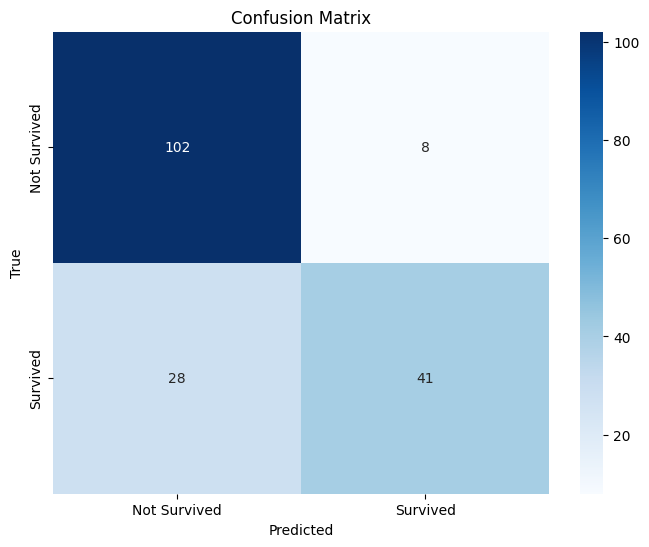

Confusion matrix saved successfully at /kaggle/working/confusion_matrix.png


In [20]:
try:
    cm = confusion_matrix(val_true, val_pred)
    print(f"Confusion Matrix:\n{cm}")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('/kaggle/working/confusion_matrix.png')
    plt.show()
    plt.close()
    if os.path.exists('/kaggle/working/confusion_matrix.png'):
        print("Confusion matrix saved successfully at /kaggle/working/confusion_matrix.png")
    else:
        print("Failed to save confusion matrix")
except Exception as e:
    print(f"Error in confusion matrix plotting: {str(e)}")

## 20. Training and Validation Loss Curves
- Functionality:
    - <span style="color:orange">plt.figure(figsize=(10, 6))</span>: Creates a plot with dimensions 10x6 inches.
    - <span style="color:orange">plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')</span>: Plots the training loss (train_losses, collected during the training loop) against epoch numbers (1 to 100).
    - <span style="color:orange">plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')</span>: Plots the validation loss (<span style="color:orange">val_losses</span>, collected during the training loop) against epochs.
    - <span style="color:orange">plt.title, plt.xlabel, plt.ylabel</span>: Sets the title and axis labels.
    - <span style="color:orange">plt.legend()</span>: Adds a legend to distinguish training and validation curves.
    - <span style="color:orange">plt.grid(True)</span>: Adds a grid for better readability.
    - <span style="color:orange">plt.savefig('/kaggle/working/loss_curves.png')</span>: Saves the plot to Kaggle’s output directory.
    - <span style="color:orange">plt.close()</span>: Closes the plot to free memory.
<br><br>
- Loss curves show how the model’s error (negative log-likelihood loss in your case) decreases over time for both training and validation sets. This is crucial for diagnosing model behavior:
    - If training loss decreases but validation loss plateaus or increases, the model is overfitting.
    - If both losses are high, the model is underfitting.
- For the Titanic dataset, this helps you determine if the GCN is learning meaningful patterns in the graph structure or if it’s memorizing the training data.

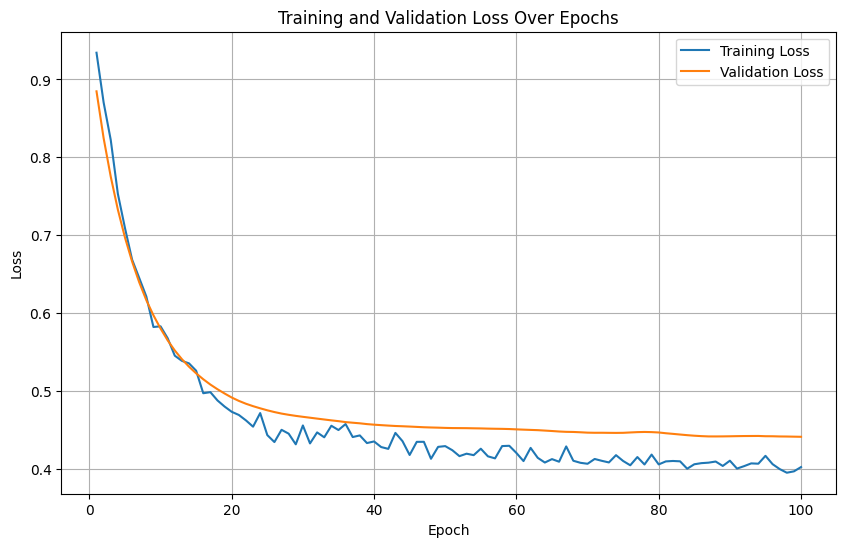

Loss curves saved successfully at /kaggle/working/loss_curves.png, Size: 45668 bytes


In [21]:
try:
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('/kaggle/working/loss_curves.png')
    plt.show()
    plt.close()
    if os.path.exists('/kaggle/working/loss_curves.png'):
        print(f"Loss curves saved successfully at /kaggle/working/loss_curves.png, Size: {os.path.getsize('/kaggle/working/loss_curves.png')} bytes")
    else:
        print("Failed to save loss curves")
except Exception as e:
    print(f"Error in loss curve plotting: {str(e)}")

## 21. ROC Curve
- Functionality:
    - <span style="color:orange">roc_curve(val_true, val_probs)</span>: Computes the Receiver Operating Characteristic (ROC) curve, returning:
        - <span style="color:orange">fpr</span>: False Positive Rate (FPR = False Positives / (False Positives + True Negatives))
        - <span style="color:orange">tpr</span>: True Positive Rate (TPR = True Positives / (True Positives + False Negatives), also called recall).
    - <span style="color:orange">_</span>: Thresholds, ignored here.
    - <span style="color:orange">val_probs</span>: Probabilities for class 1 (Survived), used to evaluate performance at different classification thresholds.
    - <span style="color:orange">roc_auc = auc(fpr, tpr)</span>: Computes the Area Under the Curve (AUC) using the trapezoidal rule, quantifying the ROC curve’s quality.
    - <span style="color:orange">plt.figure(figsize=(8, 6))</span>: Creates a plot with dimensions 8x6 inches.
    - <span style="color:orange">plt.plot(fpr, tpr, ...)</span>: Plots the ROC curve with:
        - <span style="color:orange">color='darkorange'</span>: Orange color for visibility.
        - <span style="color:orange">lw=2</span>: Line width of 2.
        - <span style="color:orange">label=f'ROC curve (AUC = {roc_auc:.2f})'</span>: Labels the curve with the AUC value.
    - <span style="color:orange">plt.plot([0, 1], [0, 1], ...)</span>: Plots a diagonal dashed line (random classifier baseline, AUC = 0.5).
    - <span style="color:orange">plt.xlim, plt.ylim</span>: Sets axis limits for clarity.
    - <span style="color:orange">plt.xlabel, plt.ylabel, plt.title</span>: Sets axis labels and title.
    - <span style="color:orange">plt.legend(loc='lower right')</span>: Places the legend in the lower-right corner.
    - <span style="color:orange">plt.grid(True)</span>: Adds a grid.
    - <span style="color:orange">plt.savefig('/kaggle/working/roc_curve.png')</span>: Saves the plot to Kaggle’s output directory.
    - <span style="color:orange">plt.close()</span>: Closes the plot.
<br><br>
- The ROC curve evaluates the model’s ability to distinguish between classes (Survived vs. Not Survived) across all possible thresholds. A higher AUC (closer to 1) indicates better performance; AUC = 0.5 suggests random guessing.
- For the Titanic dataset, where survival prediction involves imbalanced classes, the ROC curve helps assess how well the model balances sensitivity (detecting survivors) and specificity (avoiding false positives).

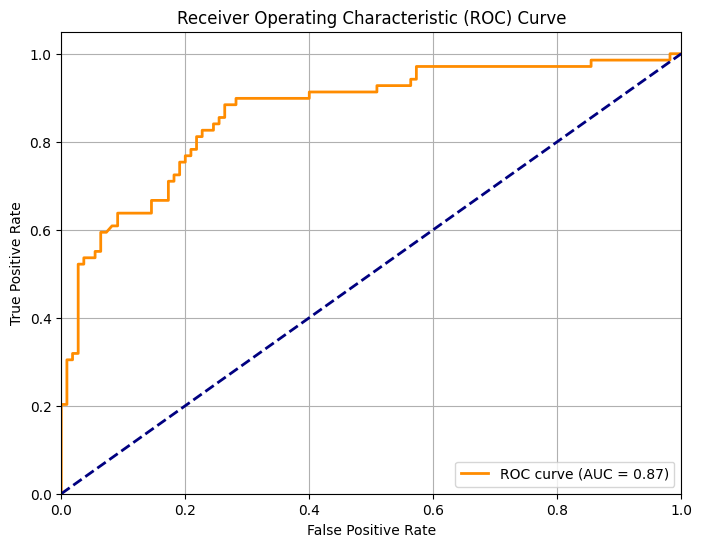

ROC curve saved successfully at /kaggle/working/roc_curve.png, Size: 38541 bytes


In [22]:
try:
    fpr, tpr, _ = roc_curve(val_true, val_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig('/kaggle/working/roc_curve.png')
    plt.show()
    plt.close()
    if os.path.exists('/kaggle/working/roc_curve.png'):
        print(f"ROC curve saved successfully at /kaggle/working/roc_curve.png, Size: {os.path.getsize('/kaggle/working/roc_curve.png')} bytes")
    else:
        print("Failed to save ROC curve")
except Exception as e:
    print(f"Error in ROC curve plotting: {str(e)}")

**Static Visualization with NetworkX and Matplotlib**
* Graph Creation: nx.Graph() creates an undirected graph, and add_edges_from(edges) uses the edges array from your k-NN computation.
* Node Colors: Nodes are colored based on y (green for Survived, red for Not Survived) to highlight survival patterns.
* Layout: nx.spring_layout positions nodes to minimize edge crossings, with seed=42 for reproducibility.
* Visualization: nx.draw renders the graph with small nodes (node_size=50 for full graph, 100 for subgraph) to handle the large number of nodes. Labels are omitted to avoid clutter.
* Saving: The plot is saved to /kaggle/working/, consistent with your project’s output directory (e.g., for confusion matrix, loss curves).
* Subgraph: The subgraph option reduces the number of nodes to 100, making the visualization clearer while still showing the k-NN structure.

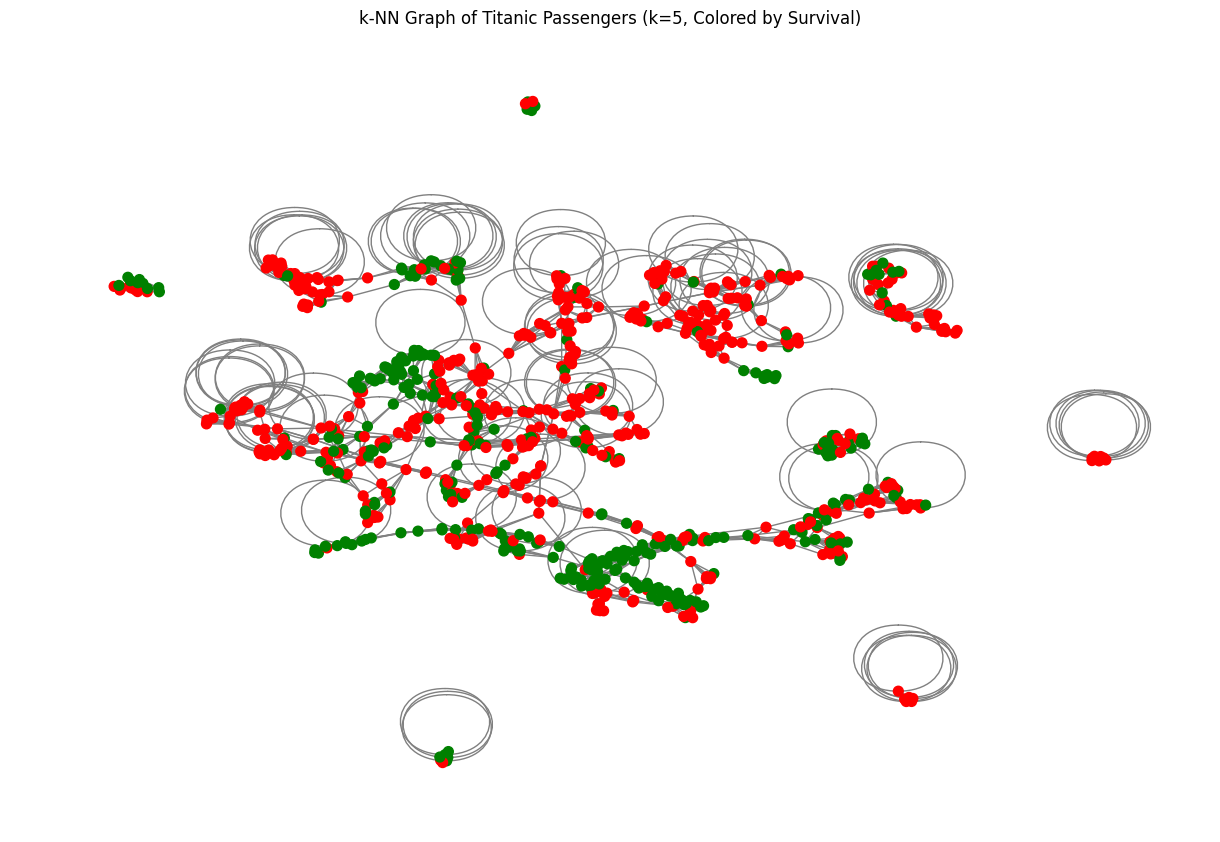

Graph visualization saved successfully at /kaggle/working/titanic_knn_graph.png, Size: 254895 bytes


In [23]:
import networkx as nx
import matplotlib.pyplot as plt

# Create NetworkX graph
G = nx.Graph()
G.add_nodes_from(range(len(y)))  # Add 891 nodes
G.add_edges_from(edges)          # Add edges from k-NN

# Node colors based on survival status
node_colors = ['green' if label == 1 else 'red' for label in y]

# Visualize the full graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Fixed layout for reproducibility
nx.draw(G, pos, node_color=node_colors, node_size=50, edge_color='gray', with_labels=False)
plt.title('k-NN Graph of Titanic Passengers (k=5, Colored by Survival)')
plt.savefig('/kaggle/working/titanic_knn_graph.png')
plt.show()
plt.close()

# Check if the file was saved
import os
if os.path.exists('/kaggle/working/titanic_knn_graph.png'):
    print(f"Graph visualization saved successfully at /kaggle/working/titanic_knn_graph.png, Size: {os.path.getsize('/kaggle/working/titanic_knn_graph.png')} bytes")
else:
    print("Failed to save graph visualization")

**Subgraph Visualization**

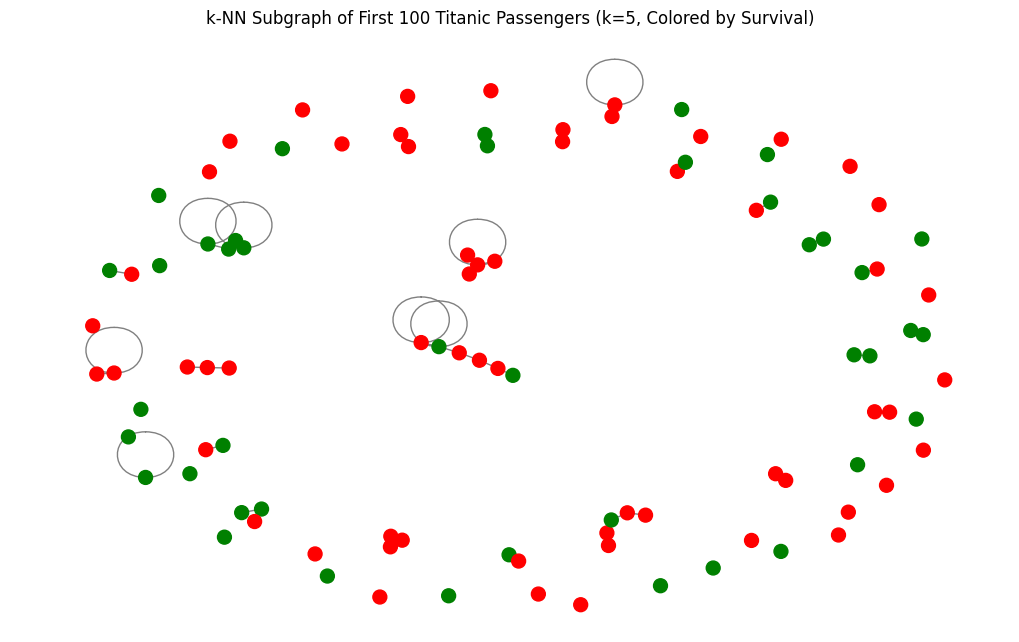

Subgraph visualization saved successfully at /kaggle/working/titanic_knn_subgraph.png, Size: 52043 bytes


In [24]:
# Subgraph for first 100 nodes
sub_nodes = range(100)
sub_edges = [edge for edge in edges if edge[0] in sub_nodes and edge[1] in sub_nodes]
G = nx.Graph()
G.add_nodes_from(sub_nodes)
G.add_edges_from(sub_edges)
node_colors = ['green' if y[i] == 1 else 'red' for i in sub_nodes]

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_color=node_colors, node_size=100, edge_color='gray', with_labels=False)
plt.title('k-NN Subgraph of First 100 Titanic Passengers (k=5, Colored by Survival)')
plt.savefig('/kaggle/working/titanic_knn_subgraph.png')
plt.show()
plt.close()

if os.path.exists('/kaggle/working/titanic_knn_subgraph.png'):
    print(f"Subgraph visualization saved successfully at /kaggle/working/titanic_knn_subgraph.png, Size: {os.path.getsize('/kaggle/working/titanic_knn_subgraph.png')} bytes")
else:
    print("Failed to save subgraph visualization")

**Interactive Visualization with PyVis**

In [25]:
!pip install pyvis
from pyvis.network import Network
import networkx as nx
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 11.2 MB/s eta 0:00:00a 0:00:01


In [26]:
# Debug: Verify edges and node types
print("Edges shape:", edges.shape)
print("Sample edges:", edges[:5])
print("Edge types:", [type(e[0]) for e in edges[:5]], [type(e[1]) for e in edges[:5]])
print("Unique node IDs:", np.unique(edges))
print("Node ID types:", [type(n) for n in np.unique(edges)][:5])

Edges shape: (6095, 2)
Sample edges: [[  0 267]
 [  0 371]
 [  0 442]
 [  0 664]
 [  0 704]]
Edge types: [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>] [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]
Unique node IDs: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 1

In [27]:
# Create NetworkX graph
G = nx.Graph()
G.add_nodes_from(range(len(y)))  # Nodes 0 to 890
G.add_edges_from(edges)

In [28]:
# Debug: Verify NetworkX graph
print("Node types in G:", [type(n) for n in list(G.nodes())][:5])
print("Edge sample in G:", list(G.edges())[:5])

Node types in G: [<class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>]
Edge sample in G: [(0, 267), (0, 371), (0, 442), (0, 664), (0, 704)]


In [29]:
try:
    # Create PyVis network
    net = Network(notebook=True, height="500px", width="100%", directed=False, cdn_resources='in_line')
    
    # Manually add nodes and edges
    for node in G.nodes():
        net.add_node(int(node), color='green' if y[node] == 1 else 'red', title=f'Passenger {node}, Survived: {y[node]}')
    for edge in G.edges():
        net.add_edge(int(edge[0]), int(edge[1]))
    
    # Save the HTML file
    output_path = '/kaggle/working/titanic_knn_graph.html'
    net.show(output_path)
    
    # Verify file exists and is readable
    if os.path.exists(output_path):
        file_size = os.path.getsize(output_path)
        print(f"Interactive graph saved at {output_path}, Size: {file_size} bytes")
        with open(output_path, 'r') as f:
            first_line = f.readline()
            print("First line of HTML:", first_line)  # Check file content
    else:
        print(f"Failed to save interactive graph at {output_path}")
except Exception as e:
    print(f"PyVis error: {str(e)}")


/kaggle/working/titanic_knn_graph.html
Interactive graph saved at /kaggle/working/titanic_knn_graph.html, Size: 870837 bytes
First line of HTML: <html>



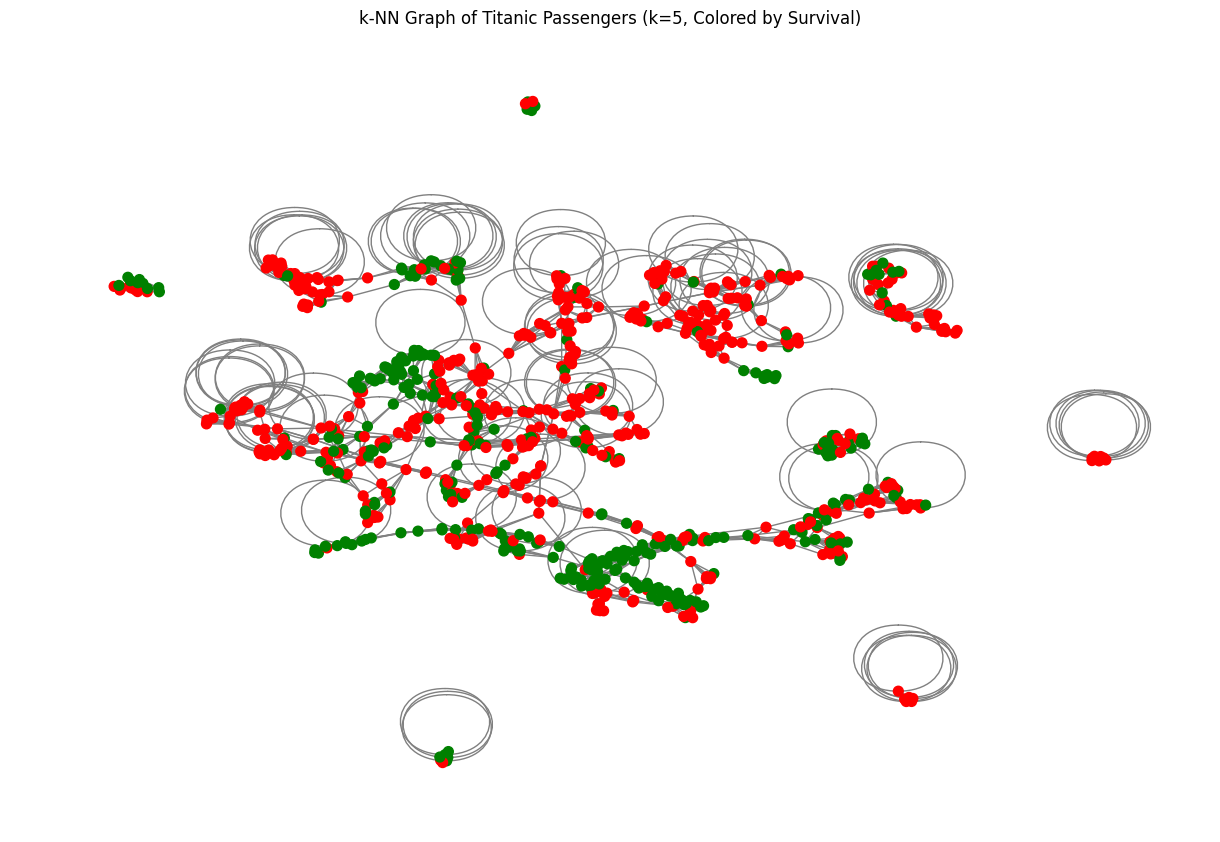

Graph visualization saved successfully at /kaggle/working/titanic_knn_graph.png, Size: 254895 bytes


In [30]:
edges = np.unique(np.array(edges), axis=0)

import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()
G.add_nodes_from(range(len(y)))
G.add_edges_from(edges)
node_colors = ['green' if label == 1 else 'red' for label in y]
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_color=node_colors, node_size=50, edge_color='gray', with_labels=False)
plt.title('k-NN Graph of Titanic Passengers (k=5, Colored by Survival)')
plt.savefig('/kaggle/working/titanic_knn_graph.png')
plt.show()
plt.close()
if os.path.exists('/kaggle/working/titanic_knn_graph.png'):
    print(f"Graph visualization saved successfully at /kaggle/working/titanic_knn_graph.png, Size: {os.path.getsize('/kaggle/working/titanic_knn_graph.png')} bytes")
else:
    print("Failed to save graph visualization")

* Graph Density: With 891 nodes and ~2230 edges, the full graph may be dense. The subgraph option (100 nodes) is recommended for clearer visualization.
* Performance: The static NetworkX plot is fast and lightweight. PyVis may be slower for 891 nodes but offers interactivity. Test both in your Kaggle environment.
* Saving: Outputs are saved to /kaggle/working/, consistent with your project. If you’re using Google Drive (as in your previous code), replace the path with /content/drive/My Drive/ after mounting Drive with drive.mount('/content/drive').
* Dependencies: Your code already includes matplotlib and numpy. Install networkx with !pip install networkx if needed (though it’s often pre-installed in Kaggle). PyVis requires !pip install pyvis.
* Chart Misinterpretation: Your request for “grph” refers to the k-NN graph, not a Chart.js chart. If you meant a chart (e.g., node degree distribution), I can provide one.

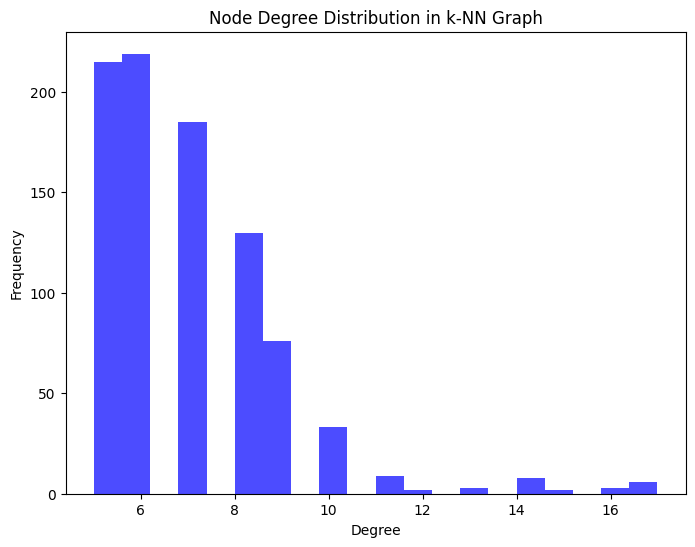

In [31]:
degrees = [d for n, d in G.degree()]
plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=20, color='blue', alpha=0.7)
plt.title('Node Degree Distribution in k-NN Graph')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.savefig('/kaggle/working/degree_distribution.png')
plt.show()
plt.close()